In [8]:
import dicom
from dicom.errors import InvalidDicomError

import numpy as np
import pylab as plb

from PIL import Image, ImageDraw
    
class Parsing_Methods():

    """Parsing code for DICOMS and contour files"""

    import dicom
    from dicom.errors import InvalidDicomError

    import numpy as np
    from PIL import Image, ImageDraw

    @staticmethod
    def parse_contour_file(filename):
        """Parse the given contour filename

        :param filename: filepath to the contourfile to parse
        :return: list of tuples holding x, y coordinates of the contour
        """

        coords_lst = []

        with open(filename, 'r') as infile:
            for line in infile:
                coords = line.strip().split()

                x_coord = float(coords[0])
                y_coord = float(coords[1])
                coords_lst.append((x_coord, y_coord))

        return coords_lst

    @staticmethod
    def parse_dicom_file(filename):
        """Parse the given DICOM filename

        :param filename: filepath to the DICOM file to parse
        :return: dictionary with DICOM image data
        """

        try:
            dcm = dicom.read_file(filename)
            dcm_image = dcm.pixel_array

            try:
                intercept = dcm.RescaleIntercept
            except AttributeError:
                intercept = 0.0
            try:
                slope = dcm.RescaleSlope
            except AttributeError:
                slope = 0.0

            if intercept != 0.0 and slope != 0.0:
                dcm_image = dcm_image*slope + intercept
            dcm_dict = {'pixel_data' : dcm_image}
            return dcm_dict
        except InvalidDicomError:
            return None

    @staticmethod
    def poly_to_mask(polygon, width, height):
        """Convert polygon to mask

        :param polygon: list of pairs of x, y coords [(x1, y1), (x2, y2), ...]
         in units of pixels
        :param width: scalar image width
        :param height: scalar image height
        :return: Boolean mask of shape (height, width)
        """

        # http://stackoverflow.com/a/3732128/1410871
        img = Image.new(mode='L', size=(width, height), color=0)
        ImageDraw.Draw(img).polygon(xy=polygon, outline=0, fill=1)
        mask = np.array(img).astype(bool)
        return mask
    
    @staticmethod 
    def draw_polygon_overlay(polygon, *args ):
        ## given a polygon and a list of input numerical images, this function plots the images and overlays the polygon 
        ## on the images. Specifically, args can be a list of one or both of [mask,dicom_image]
        for x in args:
            plb.figure()
            plb.imshow(x); 
            plb.xlim(0,shape(x)[0]); plb.ylim(0,shape(x)[1])
            plb.plot([a[0] for a in polygon], [a[1] for a in polygon], 'w', markersize=2)
        plb.show()
    

In [15]:
import re
import os
import inspect
import pandas as pd
import random as rnd

class DataHandler(object):
    def __init__(self,mainpath=None):
        if mainpath is None: 
            self.mainpath_ = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
        else:
            self.mainpath_ = mainpath 
        
        self.dicomBasePath_ = os.path.join(self.mainpath_,'dicoms')
        self.contourBasePath_ = os.path.join(self.mainpath_,'contourfiles')
        self.link_file_ = os.path.join(self.mainpath_,'link.csv')
        
    def id_map(self,renew=False):
        if (not hasattr(self,'id_links_')) or renew:
            links_df = pd.read_csv(self.link_file_)
            self.id_links_ = dict(zip(links_df.original_id, links_df.patient_id))
        return self.id_links_;
        
    def training_pairs(self,renew=False):
        dicomPathNameTraining = []
        contourPathNameTraining = []
        if (not hasattr(self,'dicom_contour_fn_pairs_')) or renew:
            self.dicom_contour_fn_pairs_ = []
            for contoursFName,dicomFName in self.id_map().iteritems():
                p = os.path.join(self.contourBasePath_, contoursFName,'i-contours' )
                if os.path.exists(p):
                    for f in os.listdir(p):
                        contourname = p + '/' + f
                        b=re.findall(r'\d\w*', f)
                        #fileNumbers.append(b[1])
                        dicomname = os.path.join(self.dicomBasePath_,dicomFName)
                        bt=str(int(b[1]))
                        dicomPathName = os.path.join(dicomname,bt + '.dcm')
                        self.dicom_contour_fn_pairs_.append( (dicomPathName, contourname) )
                        #dicomPathNameTraining.append(dicomPathName)
                        #contourPathNameTraining.append(contourname)
        return self.dicom_contour_fn_pairs_
                
    def generate_training_set(self,n,use_random=True,renew=False):
        ### returns a list of dicomdata,mask,polygon tuples (all corresponding). is use_random then it selects 
        ### n such tuples at random from the databased of existing patients/images. Otherwise it returns everything 
        training = []
        label =[]
        
        data_tuples = []
        #g=general()
        indexes = rnd.sample(range(len(self.training_pairs())), n) if use_random else range(len(self.training_pairs()))
        
        for i in indexes:
            pair = self.training_pairs(renew=renew)[i]
            dcimg = Parsing_Methods.parse_dicom_file(pair[0])
            s=dcimg['pixel_data'].shape
            pg=Parsing_Methods.parse_contour_file(pair[1])
            mimg=Parsing_Methods.poly_to_mask(pg, s[0], s[1])

            data_tuples.append( (dcimg['pixel_data'], mimg, pg) )
            #training.append(dcimg['pixel_data'])
            #label.append(mimg)
        
        return data_tuples

In [30]:

import re
from numpy import *
class Analyser():
    def __init__(self,mainpath=None):
        self.mainpath = mainpath
        self.dhandle_ = DataHandler(self.mainpath)
        
    def all_data_tuples(self):
        ## returns a list of all possible trainign sets (tuples of docom,mask,polygon). polygon is 
        ## only used for verification and wont be used as part of training data in the next layer of learnin
        return self.dhande_.generate_training_set(n=0,use_random=False)
        
    def random_visual_verify(self):
        ## plots the contour and the mask for a random data point, so we can visually they match
        dcimg,mask,pg = self.dhandle_.generate_training_set(1)[0]
        Parsing_Methods.draw_polygon_overlay(pg,dcimg,mask)
    
    def random_numerical_verify1(self): 
        dcimg,mask,pg = self.dhandle_.generate_training_set(1)[0]
    
        #imshow(dcimg[0],cmap='gray')
        #show()
        
        #imshow(mimg[0],cmap='gray')
        #show()
        
        M = dcimg
        m = mask.astype(np.int)
        H = m*M
        I2 = where(m > 0)[0]
        vals = [H[I2[2*i],I2[2*i+1]] for i in range((len(I2)-1)/2)]

        #plb.plot(vals)
        #plb.show()

        #print std(vals)/median(vals)
        #hist(vals,20); 
        #show()

        I3 = where( m == 0)[0]
        vals3 = [H[I3[2*i],I3[2*i+1]] for i in range((len(I3)-1)/2)]
        #print std(vals3)/(max(vals3)-min(vals3))

        #print mean( max(vals) - array(vals)) / max(vals)
        zvals = vals- mean(vals) 
        return std(vals)/(max(vals)-min(vals))
    
    def random_numerical_verify2(self): 
        dcimg,mask,pg = self.dhandle_.generate_training_set(1)[0]
    
        #imshow(dcimg[0],cmap='gray')
        #show()
        
        #imshow(mimg[0],cmap='gray')
        #show()
        
        M = dcimg
        m = mask.astype(np.int)
        ## pointwise product of mask and numerical image
        H = m*M 
        I = where(m > 0)[0]
        ## collecting a vector of values of the image inside the True values of mask:
        vals = array( [H[I[2*i],I[2*i+1]] for i in range((len(I)-1)/2)] )  
        
        ## now we run a statistical test to verify that values of the vector vals are all "almost equal" to a constant
        ## we look at the fraction of the values of vals that do not deviate more than twice the stanard deviation of vals 
        ## from max(vals). We express this number in percentage point:
        
        return 100.0 * sum( abs(vals - max(vals)) < 2*std(vals) ) / float(len(vals) ) 
        
        #plot(vals)
        #show()

        #print std(vals)/median(vals)
        #hist(vals,20); 
        #show()

        
        #print std(vals3)/(max(vals3)-min(vals3))

        #print mean( max(vals) - array(vals)) / max(vals)
        
        zvals = vals- mean(vals) 
        return std(vals)/(max(vals)-min(vals))
    
    def random_training_set(self,n):
        tuples = self.dhandle_.generate_training_set(n)
        return [(a[0],a[1]) for a in tuples]

# Part 1: Parse the DICOM images and Contour Files


My Notes: 

We use two types of verifications here: 

1) visual verification: for a random tuple of a dicom image and corresponding contour polygon and mask data, we plot the mask and the image on two separate figures, and overlay the polygon contour on both of the figures. visual exaimination of mask/contour approves the accuracy of contour parsing, while examining the other image verifies that the contour correctly belongs to the selected image. 

2) numerical verification: we run a statistical test to verify that values of the image inside the mask of contour are all  "almost equal". The simplest metric I came up with wasto look at the fraction of the values that do not deviate more than twice the stanard deviation. We express this number in percentage point, and ideally we would like this percentage to be close to 100. Anything less than 50% is probably a rejection (this is not a very statsitically sound claim, and I can probably improve this metric in the future). 

The distribution of the points inside the contour is extracted. Two criteia are defined which I am not sure which one is the best:

a) std(ROI)/(max(ROI)-min(ROI))

b) (ROI(x,y) - mean)< 2*sigma...we will count the number of points that have obey this condition and find the probabality of the points that are satisfying this condition. The higher probability the higher the mask is accurate and cover the ROI.


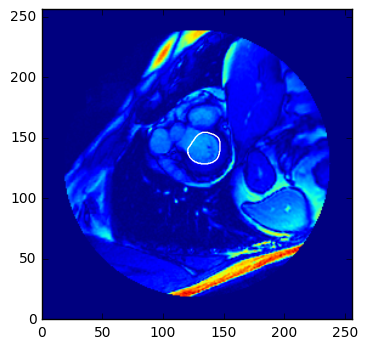

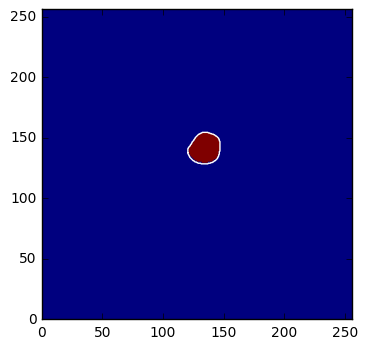

76.254180602 0.325203572019


In [31]:
p1=Analyser('//Users//behnaz//interviews//arterys//final_data//')
#print 'numerical verification: percentage of numerical match inside the mask:  %.2f'%(p1.random_numerical_verify2())
p1.random_visual_verify()
a2 = p1.random_numerical_verify2()
a1 = p1.random_numerical_verify1()
print a2,a1


# Part 2: Model training pipeline
We want to cycle throught the directories to read the dicom files and the contour files.
The link.csv file shows the link between the folder name of the contours and dicom files. The information of this file is read and saved in a dictionary so we can use that to get the dicom images and corresponding masks.

Number of the label files are smaller than the number of the dicom files, so for training any classifier and randomly choosing between files we need to find the corresponding files in contour and dicom folders.

The contour folders are read and the the file name which is in the middle of the name of the txt file is extracted using regular expression. The number is searched in the corresponding folder of the patient and finally the paths of dicom and contour files are saved.

The next step is to use a random generator to get randomly some of the training dicom files and their labels.